In [150]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
from bioage_framework.chat_model import ChatModel
import config

### Initialize a chatbot and test that it works

In [152]:
chatbot = ChatModel(url=config.URL_CB, api_key=config.API_KEY_CB, chatbot_id=config.ID_CB)
res = chatbot.query('What does an increased level of albumin mean?')
print(res)

(True, 'An increased level of albumin in the blood typically indicates a normal or healthy state. Albumin is a protein produced by the liver and plays a crucial role in maintaining fluid balance in the body. It helps attract the proper amount of fluid back from cellular spaces to the bloodstream. So, an increased level of albumin suggests that the body is effectively maintaining fluid balance.')


### Get a bioage model

In [153]:
from pathlib import Path
import os
import shap
import numpy as np
import pickle
import torch
from txai_omics_3.src.models.tabular.widedeep.ft_transformer import WDFTTransformerModel

root_dir = Path(os.getcwd()).parent

# model
fn_model = f"{root_dir}/samples/txai_omics_3/data/immuno/model.ckpt"
model = WDFTTransformerModel.load_from_checkpoint(checkpoint_path=fn_model)


# SHAP
fn_shap = f"{root_dir}/samples/txai_omics_3/data/immuno/shap.pickle"

def predict_func(x):
    batch = {
        'all': torch.from_numpy(np.float32(x)),
        'continuous': torch.from_numpy(np.float32(x)),
        'categorical': torch.from_numpy(np.int32(x[:, []])),
    }
    return model(batch).cpu().detach().numpy()

with open(fn_shap, 'rb') as handle:
    shap_dict = pickle.load(handle)
values_train = shap_dict['values_train']
shap_values_train = shap_dict['shap_values_train']
explainer = shap_dict['explainer']

Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v2.2.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint h:\Lobachevsky\FrameworkLib\samples\txai_omics_3\data\immuno\model.ckpt`
h:\Lobachevsky\FrameworkLib\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


### Load data

In [154]:
import pandas as pd

my_data = {'CXCL9': 2599.629474, 
           'CCL22': 820.306524, 
           'IL6': 0.846377, 
           'PDGFB': 13400.666359, 
           'CD40LG': 1853.847406, 
           'IL27': 1128.886982,
           'VEGFA': 153.574220,
           'CSF1': 239.627236,
           'PDGFA': 1005.844290,
           'CXCL10': 228.229829,
           'Age': 90.454972 }

my_df = pd.DataFrame(my_data, index=[0])

### Initialize a connector

In [170]:
from bioage_framework.connector import Connector

connector = Connector(bioage_model=model, chat_model=chatbot)

### Run an analysis task

In [171]:
res = connector.analyze(data=my_df, shap_dict=shap_dict)
print(res)

You biological age is 79, and you aging acceleration is -11, which means you are ageing slower than normal.

Here is some more information about your data. 

CXCL9: 11.48584016078576
An increased level of CXCL9 indicates an activation of the inflammatory immune response and is associated with systemic chronic inflammation, aging of the cardiovascular system, and impaired vascular elasticity.

CD40LG: 9.278562267126814
Hmm, I am not sure.




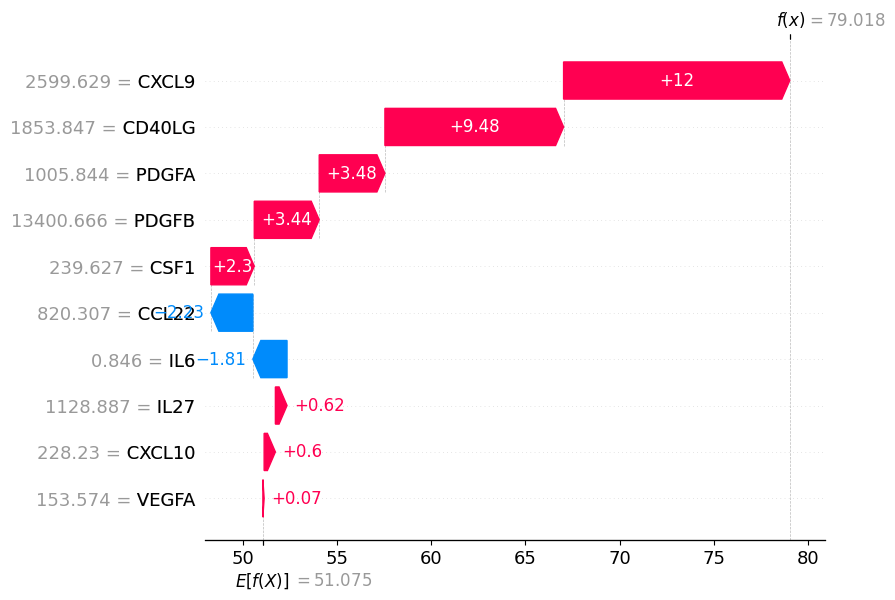

In [172]:
feats = [
    'CXCL9',
    'CCL22',
    'IL6',
    'PDGFB',
    'CD40LG',
    'IL27',
    'VEGFA',
    'CSF1',
    'PDGFA',
    'CXCL10'
]

trgt_id = 0
shap_values_trgt = explainer.shap_values(my_df.loc[trgt_id, feats].values)
base_value = explainer.expected_value[0]

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_trgt,
        base_values=base_value,
        data=my_df.loc[trgt_id, feats].values,
        feature_names=feats
    ),
    max_display=len(feats),
    show=True,
)